In [1]:
!pip install cdsapi xarray pandas numpy scikit-learn tensorflow matplotlib netcdf4

In [1]:
import cdsapi
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [18]:
# Replace with your actual UID and API key from https://cds.climate.copernicus.eu/api-how-to


c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '2m_temperature',
            'surface_pressure',
            'total_cloud_cover',
            '10m_u_component_of_wind',
            '10m_v_component_of_wind'
        ],
        'year': '2022',
        'month': ['01', '02', '03'],
        'day': ['01', '02', '03', '04', '05', '06', '07'],
        'time': ['00:00', '06:00', '12:00', '18:00'],
        'format': 'netcdf',
        'area': [52.6, 13.3, 52.4, 13.5],  # Berlin area: North, West, South, East
    },
    'berlin_multifeature_2022.nc'
)
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            '2m_temperature',
            'surface_pressure',
            'total_cloud_cover',
            '10m_u_component_of_wind',
            '10m_v_component_of_wind'
        ],
        'year': '2022',
        'month': ['01', '02', '03'],
        'day': ['01', '02', '03', '04', '05', '06', '07'],
        'time': ['00:00', '06:00', '12:00', '18:00'],
        'format': 'netcdf',
        'area': [52.6, 13.3, 52.4, 13.5],  # Berlin area: North, West, South, East
    },
    'berlin_multifeature_2022.nc'
)


2025-05-29 00:46:06,910 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-29 00:46:07,487 INFO Request ID is 2322f781-251c-4f50-af61-f99037e0b54a
2025-05-29 00:46:07,584 INFO status has been updated to accepted
2025-05-29 00:46:40,433 INFO status has been updated to running
2025-05-29 00:48:01,878 INFO status has been updated to successful


c33557ad48dd75bf4ae8dd37b1dab08f.nc:   0%|          | 0.00/62.8k [00:00<?, ?B/s]

2025-05-29 00:48:04,117 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-29 00:48:04,638 INFO Request ID is 2bdc8549-a470-4bab-8393-a89c2a9a28b2
2025-05-29 00:48:04,745 INFO status has been updated to accepted
2025-05-29 00:48:37,745 INFO status has been updated to successful


c33557ad48dd75bf4ae8dd37b1dab08f.nc:   0%|          | 0.00/62.8k [00:00<?, ?B/s]

'berlin_multifeature_2022.nc'

In [19]:
# Load dataset (already downloaded)
ds = xr.open_dataset('berlin_multifeature_2022.nc')

df = pd.DataFrame({
    'temperature': ds['t2m'].values.flatten(),
    'pressure': ds['sp'].values.flatten(),
    'cloud_cover': ds['tcc'].values.flatten(),
    'u_wind': ds['u10'].values.flatten(),
    'v_wind': ds['v10'].values.flatten()
})

# Convert temperature from Kelvin to Celsius (optional but recommended)
df['temperature'] -= 273.15

In [20]:
# Drop any NaNs
df.dropna(inplace=True)

In [21]:
# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [22]:
# Create sequences for supervised learning (e.g., predict next value from past 10 time steps)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])  # predict temperature
    return np.array(X), np.array(y)

SEQ_LEN = 10
X, y = create_sequences(scaled_data, SEQ_LEN)

In [23]:
# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [24]:
# Build the LSTM model
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(SEQ_LEN, X.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

C:\Users\super brands\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - loss: 0.1212 - val_loss: 0.0181
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0532 - val_loss: 0.0232
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0279 - val_loss: 0.0439
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0342 - val_loss: 0.0607
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0360 - val_loss: 0.0576
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0397 - val_loss: 0.0428
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0305 - val_loss: 0.0312
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0259 - val_loss: 0.0251
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0272 - val_loss: 0.0228
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0269 - val_loss: 0.0233
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0250 - val_loss: 0.0257
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0242 - val_loss:

In [26]:
# Predict and evaluate
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [29]:
# Invert scaling for temperature only
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), 
                                                         np.zeros((len(y_test), X.shape[2] - 1))], axis=1))[:, 0]
y_pred_actual = scaler.inverse_transform(np.concatenate([y_pred, 
                                                         np.zeros((len(y_pred), X.shape[2] - 1))], axis=1))[:, 0]


In [30]:
# Metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

In [31]:
# Metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'MAE: {mae:.2f} °C')
print(f'RMSE: {rmse:.2f} °C')
print(f'R²: {r2:.2f}')

MAE: 4.18 °C
RMSE: 4.72 °C
R²: -2.33


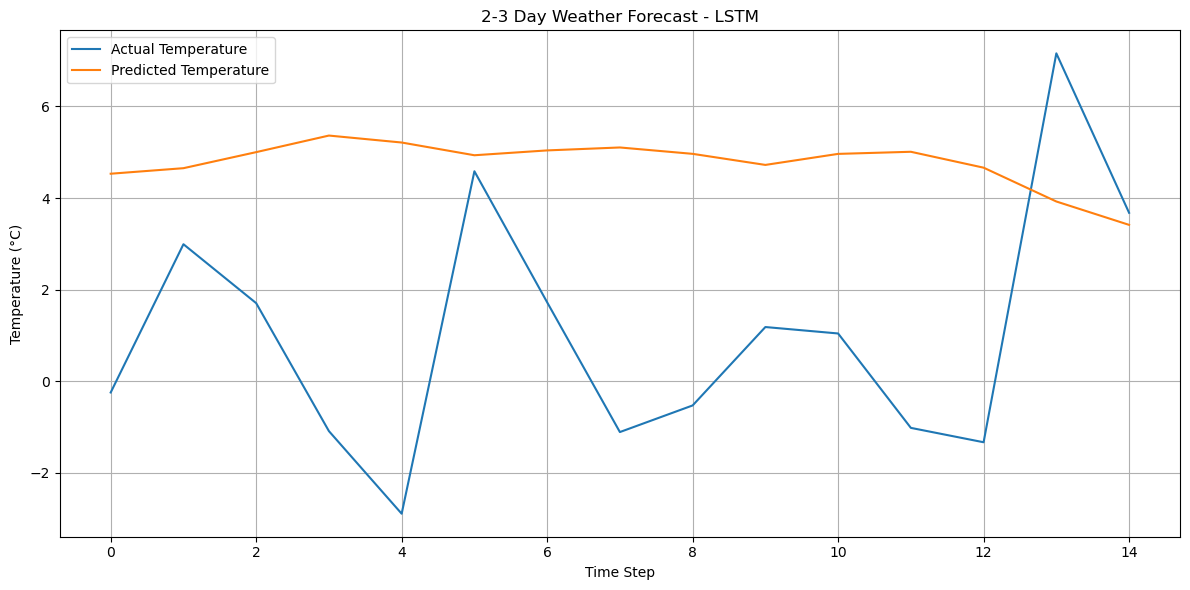

In [32]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Temperature')
plt.plot(y_pred_actual, label='Predicted Temperature')
plt.title('2-3 Day Weather Forecast - LSTM')
plt.xlabel('Time Step')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
#with open("C:/Users/super brands/.cdsapirc", "w") as f:
    #f.write("""url: https://cds.climate.copernicus.eu/api
#key: 6e3ad314-3009-4cdd-aed6-43068d594f1f""")
